In [36]:
!pip install torchinfo

In [37]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt

from torchvision import models
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchinfo import summary

from torch.utils.tensorboard import SummaryWriter

import albumentations as alb
from albumentations.pytorch import ToTensorV2

In [38]:
vgg16 = models.vgg16()
resnet18 = models.resnet18()

In [39]:
summary(vgg16)

Layer (type:depth-idx)                   Param #
VGG                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       36,928
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
│    └─Conv2d: 2-6                       73,856
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       147,584
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
│    └─Conv2d: 2-11                      295,168
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      590,080
│    └─ReLU: 2-14                        --
│    └─Conv2d: 2-15                      590,080
│    └─ReLU: 2-16                        --
│    └─MaxPool2d: 2-17                   --
│    └─Conv2d: 2-18                      1,180,160
│    └─ReLU: 2-19                

In [40]:
summary(resnet18)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  36,864
│    │    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11                 73,728

In [41]:
# # forward pass to get dynamic computational graph
# input_batch = torch.ones((4, 3, 448, 448))

# class TwoModels(nn.Module):
#     def __init__(self, vgg, resnet):
#         super().__init__()
#         self.vgg = vgg
#         self.resnet = resnet

#     def forward(self, x):
#         return self.vgg(x), self.resnet(x)

# combo = TwoModels(vgg16, resnet18)
# writer = SummaryWriter(log_dir="logs/vgg16_resnet18_graphs")
# writer.add_graph(combo, input_batch)
# writer.close()

### Backbone weights

- vgg16
- resnet18

In [42]:
vgg16_pretrained = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
resnet18_pretrained = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

### CIFAR 10 Classess

In [43]:
transform = transforms.Compose([
    transforms.PILToTensor()
])


train_dataset = datasets.CIFAR10(root=".", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root=".", train=False, download=True, transform=transform)


train_loader = DataLoader(train_dataset, 4, True, num_workers=0)
test_loader = DataLoader(test_dataset, 4, False, num_workers=0)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

truck


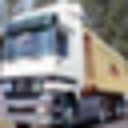

In [44]:
toPIL = transforms.ToPILImage()

def example(dataset, i):
    print(classes[dataset[i][1]])
    return toPIL(dataset[i][0])

example(train_dataset, 1).resize((128, 128))

In [45]:
len(train_dataset), len(test_dataset)

(50000, 10000)

### Augmentations with Albumentations

In [46]:
class CIFAR10Albu(datasets.CIFAR10):
    def __getitem__(self, idx):
        # image is already numpy HWC
        image, label = self.data[idx], self.targets[idx]
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, label

In [47]:
MEAN = (0.4914, 0.4822, 0.4465)
STD = (0.2470, 0.2435, 0.2616)

train_transforms = alb.Compose([
    alb.GaussNoise(p=0.2),
    alb.OneOf([
        alb.MotionBlur(p=0.2),
        alb.MedianBlur(blur_limit=3, p=0.1),
        alb.Blur(blur_limit=3, p=0.1)
    ], p=0.2),
    alb.OneOf([
        alb.OpticalDistortion(p=0.3),
        alb.GridDistortion(p=0.1),
        alb.ElasticTransform(p=0.2, alpha=64, sigma=64)
    ], p=0.2),
    alb.OneOf([
        alb.CLAHE(clip_limit=2),
        alb.Sharpen(),
        alb.Emboss()
    ], p=0.3),
    alb.HueSaturationValue(p=0.3),
    alb.HorizontalFlip(),
    alb.RGBShift(),
    alb.RandomBrightnessContrast(),
    alb.RandomGamma(),
    alb.CoarseDropout(num_holes_range=(1, 4), hole_height_range=(0.1, 0.2), hole_width_range=(0.1, 0.2)),
    alb.Normalize(mean=MEAN, std=STD),
    ToTensorV2()
])


test_transforms = alb.Compose([
    alb.Normalize(mean=MEAN, std=STD),
    ToTensorV2()
])

In [48]:
def denormalize(batch):
    mean = torch.tensor(MEAN).view(3, 1, 1)
    std = torch.tensor(STD).view(3, 1, 1)
    return batch * std + mean

In [49]:
batch_size = 256

train_dataset = CIFAR10Albu(root='.', train=True, download=False, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

test_dataset = CIFAR10Albu(root='.', train=False, download=False, transform=test_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [50]:
def visualize_batch(original, augmented, labels, figsize=(14, 6)):
    n = original.size(0)

    def grid(x):
        x = torch.clamp(denormalize(x), 0, 1)
        return make_grid(x, nrow=n).permute(1, 2, 0).cpu().numpy()

    fig, ax = plt.subplots(2, 1, figsize=figsize)

    ax[0].imshow(grid(original));  ax[0].axis("off")
    ax[1].imshow(grid(augmented)); ax[1].axis("off")

    for j, y in enumerate(labels):
        ax[0].text((j + 0.5) / n, 1.02, classes[int(y)],
                   transform=ax[0].transAxes, ha="center", va="bottom",
                   fontsize=10, fontweight="bold")

    ax[0].set_title("Original")
    ax[1].set_title("Augmented")
    plt.tight_layout()
    plt.show()


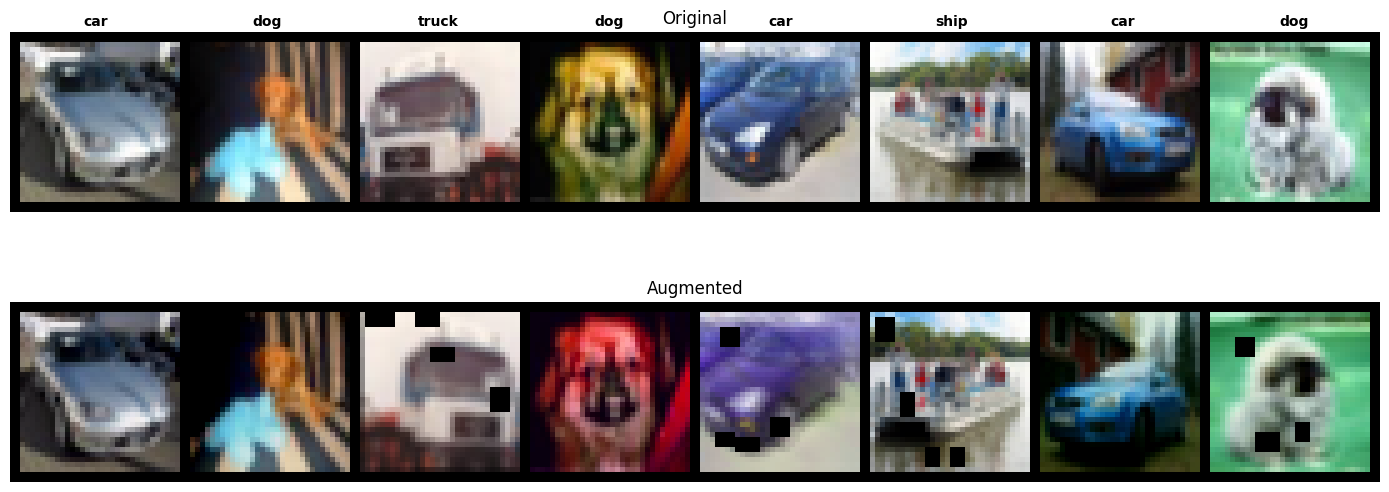

In [51]:
i = torch.randint(0, len(train_dataset), (8,))  # pick 8 paired samples

x_orig = torch.stack([test_transforms(image=train_dataset.data[k])["image"]  for k in i])
x_aug  = torch.stack([train_transforms(image=train_dataset.data[k])["image"] for k in i])
y      = torch.tensor([train_dataset.targets[k] for k in i])

visualize_batch(x_orig, x_aug, y)

### VGG16 Classifier Fat Head (Imagenet 1000 classes)

In [52]:
summary(vgg16.classifier)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Linear: 1-1                            102,764,544
├─ReLU: 1-2                              --
├─Dropout: 1-3                           --
├─Linear: 1-4                            16,781,312
├─ReLU: 1-5                              --
├─Dropout: 1-6                           --
├─Linear: 1-7                            4,097,000
Total params: 123,642,856
Trainable params: 123,642,856
Non-trainable params: 0

In [53]:
vgg16_pretrained.avgpool

AdaptiveAvgPool2d(output_size=(7, 7))

Last layer 512 feature maps\
AveragePooling 7x7

512 * 7 * 7 = 25088 dim


##### Small classifier head (CIFAR 10)

In [54]:
vgg16_pretrained.avgpool = nn.AdaptiveAvgPool2d((1, 1))
vgg16_pretrained.classifier = nn.Sequential(
    nn.Linear(512, 512, True),
    nn.ReLU(),
    nn.Linear(512, 10, True),
)

summary(vgg16_pretrained)

Layer (type:depth-idx)                   Param #
VGG                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       36,928
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
│    └─Conv2d: 2-6                       73,856
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       147,584
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
│    └─Conv2d: 2-11                      295,168
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      590,080
│    └─ReLU: 2-14                        --
│    └─Conv2d: 2-15                      590,080
│    └─ReLU: 2-16                        --
│    └─MaxPool2d: 2-17                   --
│    └─Conv2d: 2-18                      1,180,160
│    └─ReLU: 2-19                

In [55]:
vgg16_pretrained

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [56]:
# freeze layer 0 to 18
for layer in vgg16_pretrained.features[0:19]:
  for p in layer.parameters():
    p.requires_grad = False

In [57]:
summary(vgg16_pretrained)

Layer (type:depth-idx)                   Param #
VGG                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       (1,792)
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       (36,928)
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
│    └─Conv2d: 2-6                       (73,856)
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       (147,584)
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
│    └─Conv2d: 2-11                      (295,168)
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      (590,080)
│    └─ReLU: 2-14                        --
│    └─Conv2d: 2-15                      (590,080)
│    └─ReLU: 2-16                        --
│    └─MaxPool2d: 2-17                   --
│    └─Conv2d: 2-18                      (1,180,160)
│    └─ReLU: 2-19

In [58]:
def evaluate_model(model, device, data, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            bs = labels.size(0)
            total_loss += loss.item() * bs

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += bs

    avg_loss = total_loss / total
    accuracy = correct / total

    return avg_loss, accuracy

In [59]:
def train_model(model, device, data_train, data_test, optimizer, criterion, epochs=30, checkpoint=True, save_path="best_model.pt"):
    print(f"Training on: {device}")
    model = model.to(device)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    best_val_acc = 0.0

    for epoch in tqdm(range(epochs)):
        model.train()

        running_loss = 0
        total = 0
        correct = 0

        for images, labels in data_train:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)


        train_loss = running_loss / total
        train_acc = correct / total

        val_loss, val_accuracy = evaluate_model(model, device, data_test, criterion)

        if checkpoint and val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(model.state_dict(), save_path)
            print(f"BEST saved! val_acc={best_val_acc:.4f}")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_accuracy)

        writer.add_scalar("train/loss", train_loss, epoch)
        writer.add_scalar("train/accuracy", train_acc, epoch)
        writer.add_scalar("val/loss", val_loss, epoch)
        writer.add_scalar("val/accuracy", val_accuracy, epoch)

        print(
            f"Epoch [{epoch + 1}/{epochs}] "
            f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f} Acc: {val_accuracy:.4f}"
        )

    writer.close()

### Training an epoch on CIFAR on CPU and on GPU

- no augmentations
- new classifier head (small)

In [60]:
base_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

batch_size = 256

train_dataset = datasets.CIFAR10(root=".", train=True, download=True, transform=base_transform)
test_dataset = datasets.CIFAR10(root=".", train=False, download=True, transform=base_transform)


train_loader = DataLoader(train_dataset, batch_size, True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size, False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [61]:
import copy

model_gpu = copy.deepcopy(vgg16_pretrained)
model_cpu = copy.deepcopy(vgg16_pretrained)

In [62]:
%%time

writer = SummaryWriter(log_dir="logs/model_gpu")
device = torch.device("cuda")

model_gpu = model_gpu.to(device)
optimizer = torch.optim.AdamW(model_gpu.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_model(
    model_gpu,
    device,
    train_loader,
    test_loader,
    optimizer,
    criterion,
    1,
    False,
)

Training on: cuda


100%|██████████| 1/1 [00:17<00:00, 17.17s/it]

Epoch [1/1] Train Loss: 0.9054 Acc: 0.6825 | Val Loss: 0.6098 Acc: 0.7967
CPU times: user 5.98 s, sys: 454 ms, total: 6.43 s
Wall time: 17.2 s


Note: it's taking forever, I skipped

In [63]:
# %%time

# writer = SummaryWriter(log_dir="logs/model_cpu")
# device = torch.device("cpu")

# model_cpu = model_cpu.to(device)
# optimizer = torch.optim.AdamW(model_cpu.parameters(), lr=1e-3)
# criterion = nn.CrossEntropyLoss()

# train_model(
#     model_cpu,
#     device,
#     train_loader,
#     test_loader,
#     optimizer,
#     criterion,
#     1,
#     False,
# )

Old classifier head

In [64]:
model_gpu_old = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
model_cpu_old = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

In [65]:
%%time

writer = SummaryWriter(log_dir="logs/model_gpu_old_classifier")
device = torch.device("cuda")

model_gpu_old = model_gpu_old.to(device)
optimizer = torch.optim.AdamW(model_gpu_old.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_model(
    model_gpu_old,
    device,
    train_loader,
    test_loader,
    optimizer,
    criterion,
    1,
    False
)

Training on: cuda


100%|██████████| 1/1 [00:39<00:00, 39.80s/it]

Epoch [1/1] Train Loss: 2.2507 Acc: 0.2355 | Val Loss: 1.5494 Acc: 0.3820
CPU times: user 32.8 s, sys: 557 ms, total: 33.4 s
Wall time: 40 s


In [66]:
# %%time

# writer = SummaryWriter(log_dir="logs/model_cpu_old_classifier")
# device = torch.device("cpu")

# model_cpu_old = model_cpu_old.to(device)
# optimizer = torch.optim.AdamW(model_cpu_old.parameters(), lr=1e-3)
# criterion = nn.CrossEntropyLoss()

# train_model(
#     model_cpu_old,
#     device,
#     train_loader,
#     test_loader,
#     optimizer,
#     criterion,
#     1,
#     False,
# )

#### Train a CIFAR classifier based on VGG-16 with new classifier

- with augmentations
- without augmentations

In [67]:
train_dataset_augmented = CIFAR10Albu(root='.', train=True, download=False, transform=train_transforms)
train_loader_augmented = torch.utils.data.DataLoader(train_dataset_augmented, batch_size=batch_size, shuffle=True, num_workers=2)

In [68]:
model_augmented = copy.deepcopy(vgg16_pretrained)
model_noaugmented = copy.deepcopy(vgg16_pretrained)

In [69]:
%%time

writer = SummaryWriter(log_dir="logs/model_augmented")
device = torch.device("cuda")

model_augmented = model_augmented.to(device)
optimizer = torch.optim.AdamW(model_augmented.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_model(
    model_augmented,
    device,
    train_loader_augmented,
    test_loader,
    optimizer,
    criterion,
    30,
    True,
    "best_model_augmented.pt"
)

Training on: cuda


  3%|▎         | 1/30 [00:32<15:56, 33.00s/it]

BEST saved! val_acc=0.7606
Epoch [1/30] Train Loss: 1.3972 Acc: 0.5036 | Val Loss: 0.7060 Acc: 0.7606


  7%|▋         | 2/30 [01:06<15:36, 33.46s/it]

BEST saved! val_acc=0.7782
Epoch [2/30] Train Loss: 1.0683 Acc: 0.6268 | Val Loss: 0.6489 Acc: 0.7782


 10%|█         | 3/30 [01:38<14:40, 32.60s/it]

BEST saved! val_acc=0.8115
Epoch [3/30] Train Loss: 0.9894 Acc: 0.6533 | Val Loss: 0.5647 Acc: 0.8115


 13%|█▎        | 4/30 [02:11<14:10, 32.72s/it]

BEST saved! val_acc=0.8255
Epoch [4/30] Train Loss: 0.9450 Acc: 0.6720 | Val Loss: 0.5100 Acc: 0.8255


 17%|█▋        | 5/30 [02:43<13:33, 32.54s/it]

BEST saved! val_acc=0.8394
Epoch [5/30] Train Loss: 0.9054 Acc: 0.6851 | Val Loss: 0.4785 Acc: 0.8394


 20%|██        | 6/30 [03:16<13:04, 32.69s/it]

BEST saved! val_acc=0.8434
Epoch [6/30] Train Loss: 0.8807 Acc: 0.6950 | Val Loss: 0.4756 Acc: 0.8434


 23%|██▎       | 7/30 [03:48<12:25, 32.42s/it]

BEST saved! val_acc=0.8442
Epoch [7/30] Train Loss: 0.8570 Acc: 0.6999 | Val Loss: 0.4666 Acc: 0.8442


 27%|██▋       | 8/30 [04:21<11:56, 32.57s/it]

BEST saved! val_acc=0.8550
Epoch [8/30] Train Loss: 0.8381 Acc: 0.7073 | Val Loss: 0.4362 Acc: 0.8550


 30%|███       | 9/30 [04:53<11:19, 32.34s/it]

BEST saved! val_acc=0.8588
Epoch [9/30] Train Loss: 0.8211 Acc: 0.7160 | Val Loss: 0.4218 Acc: 0.8588


 33%|███▎      | 10/30 [05:25<10:50, 32.51s/it]

Epoch [10/30] Train Loss: 0.8150 Acc: 0.7172 | Val Loss: 0.4289 Acc: 0.8562


 37%|███▋      | 11/30 [05:58<10:18, 32.53s/it]

BEST saved! val_acc=0.8594
Epoch [11/30] Train Loss: 0.7912 Acc: 0.7254 | Val Loss: 0.4322 Acc: 0.8594


 40%|████      | 12/30 [06:31<09:47, 32.63s/it]

BEST saved! val_acc=0.8605
Epoch [12/30] Train Loss: 0.7872 Acc: 0.7270 | Val Loss: 0.4174 Acc: 0.8605


 43%|████▎     | 13/30 [07:03<09:12, 32.51s/it]

BEST saved! val_acc=0.8649
Epoch [13/30] Train Loss: 0.7673 Acc: 0.7326 | Val Loss: 0.4205 Acc: 0.8649


 47%|████▋     | 14/30 [07:36<08:41, 32.61s/it]

BEST saved! val_acc=0.8721
Epoch [14/30] Train Loss: 0.7617 Acc: 0.7372 | Val Loss: 0.4122 Acc: 0.8721


 50%|█████     | 15/30 [08:08<08:05, 32.40s/it]

Epoch [15/30] Train Loss: 0.7535 Acc: 0.7362 | Val Loss: 0.4184 Acc: 0.8611


 53%|█████▎    | 16/30 [08:41<07:35, 32.54s/it]

Epoch [16/30] Train Loss: 0.7426 Acc: 0.7416 | Val Loss: 0.4108 Acc: 0.8668


 57%|█████▋    | 17/30 [09:13<07:00, 32.34s/it]

Epoch [17/30] Train Loss: 0.7340 Acc: 0.7439 | Val Loss: 0.3992 Acc: 0.8713


 60%|██████    | 18/30 [09:45<06:29, 32.44s/it]

Epoch [18/30] Train Loss: 0.7280 Acc: 0.7454 | Val Loss: 0.3847 Acc: 0.8719


 63%|██████▎   | 19/30 [10:18<05:56, 32.38s/it]

BEST saved! val_acc=0.8733
Epoch [19/30] Train Loss: 0.7192 Acc: 0.7524 | Val Loss: 0.4069 Acc: 0.8733


 67%|██████▋   | 20/30 [10:50<05:23, 32.36s/it]

Epoch [20/30] Train Loss: 0.7158 Acc: 0.7507 | Val Loss: 0.3861 Acc: 0.8727


 70%|███████   | 21/30 [11:23<04:52, 32.47s/it]

Epoch [21/30] Train Loss: 0.7085 Acc: 0.7532 | Val Loss: 0.3934 Acc: 0.8723


 73%|███████▎  | 22/30 [11:55<04:19, 32.39s/it]

Epoch [22/30] Train Loss: 0.7068 Acc: 0.7542 | Val Loss: 0.3917 Acc: 0.8731


 77%|███████▋  | 23/30 [12:29<03:49, 32.82s/it]

BEST saved! val_acc=0.8736
Epoch [23/30] Train Loss: 0.6904 Acc: 0.7596 | Val Loss: 0.3943 Acc: 0.8736


 80%|████████  | 24/30 [13:01<03:16, 32.71s/it]

BEST saved! val_acc=0.8742
Epoch [24/30] Train Loss: 0.6886 Acc: 0.7600 | Val Loss: 0.3847 Acc: 0.8742


 83%|████████▎ | 25/30 [13:33<02:42, 32.48s/it]

Epoch [25/30] Train Loss: 0.6851 Acc: 0.7614 | Val Loss: 0.4103 Acc: 0.8691


 87%|████████▋ | 26/30 [14:05<02:09, 32.32s/it]

BEST saved! val_acc=0.8753
Epoch [26/30] Train Loss: 0.6845 Acc: 0.7612 | Val Loss: 0.3920 Acc: 0.8753


 90%|█████████ | 27/30 [14:38<01:37, 32.42s/it]

Epoch [27/30] Train Loss: 0.6782 Acc: 0.7644 | Val Loss: 0.4013 Acc: 0.8702


 93%|█████████▎| 28/30 [15:10<01:04, 32.35s/it]

BEST saved! val_acc=0.8755
Epoch [28/30] Train Loss: 0.6695 Acc: 0.7681 | Val Loss: 0.3892 Acc: 0.8755


 97%|█████████▋| 29/30 [15:43<00:32, 32.56s/it]

BEST saved! val_acc=0.8778
Epoch [29/30] Train Loss: 0.6710 Acc: 0.7655 | Val Loss: 0.3785 Acc: 0.8778


100%|██████████| 30/30 [16:15<00:00, 32.51s/it]

BEST saved! val_acc=0.8780
Epoch [30/30] Train Loss: 0.6651 Acc: 0.7667 | Val Loss: 0.3933 Acc: 0.8780
CPU times: user 3min 10s, sys: 15.6 s, total: 3min 25s
Wall time: 16min 15s


In [70]:
%%time

writer = SummaryWriter(log_dir="logs/model_noaugmented")
device = torch.device("cuda")

model_noaugmented = model_noaugmented.to(device)
optimizer = torch.optim.AdamW(model_noaugmented.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_model(
    model_noaugmented,
    device,
    train_loader,
    test_loader,
    optimizer,
    criterion,
    30,
    True,
    "best_model_noaugmented.pt"
)

Training on: cuda


  3%|▎         | 1/30 [00:17<08:19, 17.22s/it]

BEST saved! val_acc=0.8113
Epoch [1/30] Train Loss: 0.8785 Acc: 0.6920 | Val Loss: 0.5723 Acc: 0.8113


  7%|▋         | 2/30 [00:33<07:46, 16.67s/it]

BEST saved! val_acc=0.8364
Epoch [2/30] Train Loss: 0.4538 Acc: 0.8472 | Val Loss: 0.4822 Acc: 0.8364


 10%|█         | 3/30 [00:49<07:23, 16.41s/it]

BEST saved! val_acc=0.8549
Epoch [3/30] Train Loss: 0.3138 Acc: 0.8935 | Val Loss: 0.4513 Acc: 0.8549


 13%|█▎        | 4/30 [01:06<07:09, 16.51s/it]

Epoch [4/30] Train Loss: 0.2220 Acc: 0.9248 | Val Loss: 0.6041 Acc: 0.8314


 17%|█▋        | 5/30 [01:22<06:52, 16.51s/it]

BEST saved! val_acc=0.8585
Epoch [5/30] Train Loss: 0.1589 Acc: 0.9455 | Val Loss: 0.5583 Acc: 0.8585


 20%|██        | 6/30 [01:39<06:33, 16.41s/it]

Epoch [6/30] Train Loss: 0.1233 Acc: 0.9576 | Val Loss: 0.6128 Acc: 0.8391


 23%|██▎       | 7/30 [01:55<06:15, 16.34s/it]

Epoch [7/30] Train Loss: 0.0964 Acc: 0.9682 | Val Loss: 0.6614 Acc: 0.8551


 27%|██▋       | 8/30 [02:12<06:05, 16.60s/it]

Epoch [8/30] Train Loss: 0.0751 Acc: 0.9748 | Val Loss: 0.8406 Acc: 0.8370


 30%|███       | 9/30 [02:28<05:46, 16.52s/it]

Epoch [9/30] Train Loss: 0.0664 Acc: 0.9786 | Val Loss: 0.6849 Acc: 0.8507


 33%|███▎      | 10/30 [02:45<05:31, 16.56s/it]

Epoch [10/30] Train Loss: 0.0561 Acc: 0.9816 | Val Loss: 0.6530 Acc: 0.8572


 37%|███▋      | 11/30 [03:02<05:18, 16.75s/it]

Epoch [11/30] Train Loss: 0.0506 Acc: 0.9834 | Val Loss: 0.7925 Acc: 0.8458


 40%|████      | 12/30 [03:18<04:58, 16.59s/it]

Epoch [12/30] Train Loss: 0.0577 Acc: 0.9824 | Val Loss: 0.8573 Acc: 0.8544


 43%|████▎     | 13/30 [03:35<04:40, 16.53s/it]

Epoch [13/30] Train Loss: 0.0452 Acc: 0.9860 | Val Loss: 0.8585 Acc: 0.8492


 47%|████▋     | 14/30 [03:51<04:21, 16.34s/it]

Epoch [14/30] Train Loss: 0.0450 Acc: 0.9870 | Val Loss: 0.9053 Acc: 0.8510


 50%|█████     | 15/30 [04:07<04:05, 16.39s/it]

Epoch [15/30] Train Loss: 0.0411 Acc: 0.9875 | Val Loss: 0.8679 Acc: 0.8563


 53%|█████▎    | 16/30 [04:23<03:49, 16.40s/it]

Epoch [16/30] Train Loss: 0.0425 Acc: 0.9880 | Val Loss: 0.8364 Acc: 0.8551


 57%|█████▋    | 17/30 [04:39<03:31, 16.25s/it]

Epoch [17/30] Train Loss: 0.0379 Acc: 0.9891 | Val Loss: 0.8948 Acc: 0.8576


 60%|██████    | 18/30 [04:57<03:19, 16.62s/it]

BEST saved! val_acc=0.8586
Epoch [18/30] Train Loss: 0.0503 Acc: 0.9862 | Val Loss: 0.8042 Acc: 0.8586


 63%|██████▎   | 19/30 [05:14<03:03, 16.68s/it]

BEST saved! val_acc=0.8623
Epoch [19/30] Train Loss: 0.0340 Acc: 0.9896 | Val Loss: 1.0975 Acc: 0.8623


 67%|██████▋   | 20/30 [05:30<02:45, 16.55s/it]

Epoch [20/30] Train Loss: 0.0353 Acc: 0.9894 | Val Loss: 1.0268 Acc: 0.8555


 70%|███████   | 21/30 [05:46<02:28, 16.45s/it]

Epoch [21/30] Train Loss: 0.0421 Acc: 0.9880 | Val Loss: 0.9570 Acc: 0.8594


 73%|███████▎  | 22/30 [06:03<02:13, 16.66s/it]

Epoch [22/30] Train Loss: 0.0467 Acc: 0.9878 | Val Loss: 0.8186 Acc: 0.8563


 77%|███████▋  | 23/30 [06:20<01:56, 16.61s/it]

Epoch [23/30] Train Loss: 0.0481 Acc: 0.9869 | Val Loss: 0.9885 Acc: 0.8544


 80%|████████  | 24/30 [06:36<01:39, 16.51s/it]

Epoch [24/30] Train Loss: 0.0290 Acc: 0.9918 | Val Loss: 1.0463 Acc: 0.8616


 83%|████████▎ | 25/30 [06:53<01:23, 16.75s/it]

Epoch [25/30] Train Loss: 0.0208 Acc: 0.9942 | Val Loss: 1.1643 Acc: 0.8617


 87%|████████▋ | 26/30 [07:10<01:06, 16.61s/it]

Epoch [26/30] Train Loss: 0.0221 Acc: 0.9940 | Val Loss: 1.1324 Acc: 0.8595


 90%|█████████ | 27/30 [07:26<00:49, 16.49s/it]

Epoch [27/30] Train Loss: 0.0218 Acc: 0.9937 | Val Loss: 0.9630 Acc: 0.8568


 93%|█████████▎| 28/30 [07:43<00:33, 16.61s/it]

Epoch [28/30] Train Loss: 0.0329 Acc: 0.9910 | Val Loss: 1.5668 Acc: 0.8518


 97%|█████████▋| 29/30 [07:59<00:16, 16.58s/it]

Epoch [29/30] Train Loss: 0.0235 Acc: 0.9934 | Val Loss: 0.9902 Acc: 0.8592


100%|██████████| 30/30 [08:16<00:00, 16.54s/it]

BEST saved! val_acc=0.8630
Epoch [30/30] Train Loss: 0.0165 Acc: 0.9951 | Val Loss: 1.6607 Acc: 0.8630
CPU times: user 3min 7s, sys: 13.3 s, total: 3min 21s
Wall time: 8min 16s


#### Findings

1. **No augmentations → overfitting:** training accuracy rises fast, but validation/test plateaus lower.

2. **Strong augmentations → better generalization:** slower learning and ~2× wall time, but more robust training.

3. **Higher test accuracy with augmentations:** `~0.878` vs `~0.863` without augmentations.

4. **Further gains possible:** train longer, use LR scheduling, and unfreeze/fine-tune more backbone layers.


In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_augmented.load_state_dict(torch.load("best_model_augmented.pt", map_location=device))
model_augmented = model_augmented.to(device)

print("Loaded: best_model_augmented.pt")

Using device: cuda
Loaded: best_model_augmented.pt


In [72]:
# unfreeze all layers
for p in model_augmented.parameters():
    p.requires_grad = True

In [73]:
summary(model_augmented)

Layer (type:depth-idx)                   Param #
VGG                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       36,928
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
│    └─Conv2d: 2-6                       73,856
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       147,584
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
│    └─Conv2d: 2-11                      295,168
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      590,080
│    └─ReLU: 2-14                        --
│    └─Conv2d: 2-15                      590,080
│    └─ReLU: 2-16                        --
│    └─MaxPool2d: 2-17                   --
│    └─Conv2d: 2-18                      1,180,160
│    └─ReLU: 2-19                

In [76]:
%%time

writer = SummaryWriter(log_dir="logs2/finetune_augmented_adam")

optimizer = torch.optim.Adam(model_augmented.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

train_model(
    model_augmented,
    device,
    train_loader_augmented,
    test_loader,
    optimizer,
    criterion,
    epochs=20,
    checkpoint=True,
    save_path="best_model_augmented_unfrozen_adam.pt"
)

Training on: cuda


  5%|▌         | 1/20 [00:33<10:42, 33.80s/it]

BEST saved! val_acc=0.8759
Epoch [1/20] Train Loss: 0.6112 Acc: 0.7878 | Val Loss: 0.3957 Acc: 0.8759


 10%|█         | 2/20 [01:07<10:10, 33.89s/it]

Epoch [2/20] Train Loss: 0.5684 Acc: 0.8026 | Val Loss: 0.4069 Acc: 0.8757


 15%|█▌        | 3/20 [01:41<09:34, 33.80s/it]

BEST saved! val_acc=0.8782
Epoch [3/20] Train Loss: 0.5404 Acc: 0.8116 | Val Loss: 0.3794 Acc: 0.8782


 20%|██        | 4/20 [02:14<08:58, 33.63s/it]

Epoch [4/20] Train Loss: 0.5147 Acc: 0.8211 | Val Loss: 0.3909 Acc: 0.8748


 25%|██▌       | 5/20 [02:48<08:24, 33.61s/it]

BEST saved! val_acc=0.8840
Epoch [5/20] Train Loss: 0.5011 Acc: 0.8258 | Val Loss: 0.3797 Acc: 0.8840


 30%|███       | 6/20 [03:21<07:49, 33.51s/it]

BEST saved! val_acc=0.8870
Epoch [6/20] Train Loss: 0.4913 Acc: 0.8277 | Val Loss: 0.3763 Acc: 0.8870


 35%|███▌      | 7/20 [03:55<07:18, 33.72s/it]

Epoch [7/20] Train Loss: 0.4840 Acc: 0.8310 | Val Loss: 0.3854 Acc: 0.8862


 40%|████      | 8/20 [04:28<06:41, 33.47s/it]

Epoch [8/20] Train Loss: 0.4654 Acc: 0.8367 | Val Loss: 0.3796 Acc: 0.8834


 45%|████▌     | 9/20 [05:03<06:10, 33.70s/it]

Epoch [9/20] Train Loss: 0.4589 Acc: 0.8402 | Val Loss: 0.3893 Acc: 0.8829


 50%|█████     | 10/20 [05:37<05:38, 33.84s/it]

Epoch [10/20] Train Loss: 0.4565 Acc: 0.8419 | Val Loss: 0.3807 Acc: 0.8870


 55%|█████▌    | 11/20 [06:11<05:05, 33.91s/it]

Epoch [11/20] Train Loss: 0.4331 Acc: 0.8469 | Val Loss: 0.3768 Acc: 0.8841


 60%|██████    | 12/20 [06:45<04:32, 34.00s/it]

BEST saved! val_acc=0.8897
Epoch [12/20] Train Loss: 0.4260 Acc: 0.8502 | Val Loss: 0.3795 Acc: 0.8897


 65%|██████▌   | 13/20 [07:18<03:56, 33.73s/it]

Epoch [13/20] Train Loss: 0.4324 Acc: 0.8498 | Val Loss: 0.3850 Acc: 0.8851


 70%|███████   | 14/20 [07:53<03:23, 33.99s/it]

BEST saved! val_acc=0.8902
Epoch [14/20] Train Loss: 0.4152 Acc: 0.8571 | Val Loss: 0.3691 Acc: 0.8902


 75%|███████▌  | 15/20 [08:26<02:48, 33.76s/it]

Epoch [15/20] Train Loss: 0.4115 Acc: 0.8562 | Val Loss: 0.3787 Acc: 0.8898


 80%|████████  | 16/20 [09:00<02:15, 33.84s/it]

BEST saved! val_acc=0.8906
Epoch [16/20] Train Loss: 0.4046 Acc: 0.8589 | Val Loss: 0.3923 Acc: 0.8906


 85%|████████▌ | 17/20 [09:34<01:41, 33.90s/it]

BEST saved! val_acc=0.8917
Epoch [17/20] Train Loss: 0.4020 Acc: 0.8608 | Val Loss: 0.3803 Acc: 0.8917


 90%|█████████ | 18/20 [10:07<01:07, 33.54s/it]

Epoch [18/20] Train Loss: 0.3909 Acc: 0.8623 | Val Loss: 0.3851 Acc: 0.8917


 95%|█████████▌| 19/20 [10:40<00:33, 33.49s/it]

BEST saved! val_acc=0.8920
Epoch [19/20] Train Loss: 0.3885 Acc: 0.8649 | Val Loss: 0.3925 Acc: 0.8920


100%|██████████| 20/20 [11:12<00:00, 33.65s/it]

Epoch [20/20] Train Loss: 0.3889 Acc: 0.8661 | Val Loss: 0.3925 Acc: 0.8858
CPU times: user 3min 24s, sys: 10.4 s, total: 3min 35s
Wall time: 11min 12s


Reload, Unfreeze and finetune

In [77]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_augmented.load_state_dict(torch.load("best_model_augmented.pt", map_location=device))
model_augmented = model_augmented.to(device)

# unfreeze all layers
for p in model_augmented.parameters():
    p.requires_grad = True

print("Loaded: best_model_augmented.pt")

Using device: cuda
Loaded: best_model_augmented.pt


In [78]:
%%time

writer = SummaryWriter(log_dir="logs2/finetune_augmented_sgd")

optimizer = torch.optim.SGD(
    model_augmented.parameters(),
    lr=0.0001,
    # momentum=0.9,
    # weight_decay=5e-4,
    # nesterov=True # looking ahead
)
criterion = nn.CrossEntropyLoss()

train_model(
    model_augmented,
    device,
    train_loader_augmented,
    test_loader,
    optimizer,
    criterion,
    epochs=20,
    checkpoint=True,
    save_path="best_model_augmented_unfrozen_sgd.pt"
)

Training on: cuda


  5%|▌         | 1/20 [00:33<10:43, 33.87s/it]

BEST saved! val_acc=0.8789
Epoch [1/20] Train Loss: 0.6424 Acc: 0.7741 | Val Loss: 0.3886 Acc: 0.8789


 10%|█         | 2/20 [01:06<09:57, 33.20s/it]

Epoch [2/20] Train Loss: 0.6361 Acc: 0.7765 | Val Loss: 0.3867 Acc: 0.8784


 15%|█▌        | 3/20 [01:40<09:26, 33.32s/it]

Epoch [3/20] Train Loss: 0.6305 Acc: 0.7797 | Val Loss: 0.3852 Acc: 0.8789


 20%|██        | 4/20 [02:13<08:51, 33.20s/it]

Epoch [4/20] Train Loss: 0.6263 Acc: 0.7809 | Val Loss: 0.3839 Acc: 0.8780


 25%|██▌       | 5/20 [02:46<08:18, 33.22s/it]

Epoch [5/20] Train Loss: 0.6194 Acc: 0.7818 | Val Loss: 0.3829 Acc: 0.8788


 30%|███       | 6/20 [03:20<07:49, 33.52s/it]

Epoch [6/20] Train Loss: 0.6231 Acc: 0.7817 | Val Loss: 0.3822 Acc: 0.8783


 35%|███▌      | 7/20 [03:52<07:11, 33.19s/it]

Epoch [7/20] Train Loss: 0.6171 Acc: 0.7832 | Val Loss: 0.3820 Acc: 0.8789


 40%|████      | 8/20 [04:26<06:41, 33.44s/it]

BEST saved! val_acc=0.8792
Epoch [8/20] Train Loss: 0.6180 Acc: 0.7818 | Val Loss: 0.3810 Acc: 0.8792


 45%|████▌     | 9/20 [05:00<06:07, 33.42s/it]

BEST saved! val_acc=0.8796
Epoch [9/20] Train Loss: 0.6141 Acc: 0.7844 | Val Loss: 0.3803 Acc: 0.8796


 50%|█████     | 10/20 [05:34<05:35, 33.55s/it]

Epoch [10/20] Train Loss: 0.6112 Acc: 0.7877 | Val Loss: 0.3800 Acc: 0.8793


 55%|█████▌    | 11/20 [06:07<05:00, 33.42s/it]

BEST saved! val_acc=0.8804
Epoch [11/20] Train Loss: 0.6068 Acc: 0.7870 | Val Loss: 0.3796 Acc: 0.8804


 60%|██████    | 12/20 [06:41<04:29, 33.63s/it]

Epoch [12/20] Train Loss: 0.6149 Acc: 0.7841 | Val Loss: 0.3790 Acc: 0.8804


 65%|██████▌   | 13/20 [07:15<03:56, 33.77s/it]

BEST saved! val_acc=0.8809
Epoch [13/20] Train Loss: 0.6091 Acc: 0.7861 | Val Loss: 0.3780 Acc: 0.8809


 70%|███████   | 14/20 [07:48<03:21, 33.55s/it]

BEST saved! val_acc=0.8813
Epoch [14/20] Train Loss: 0.6027 Acc: 0.7882 | Val Loss: 0.3781 Acc: 0.8813


 75%|███████▌  | 15/20 [08:21<02:47, 33.53s/it]

BEST saved! val_acc=0.8814
Epoch [15/20] Train Loss: 0.6029 Acc: 0.7880 | Val Loss: 0.3779 Acc: 0.8814


 80%|████████  | 16/20 [08:54<02:13, 33.32s/it]

Epoch [16/20] Train Loss: 0.6007 Acc: 0.7917 | Val Loss: 0.3778 Acc: 0.8812


 85%|████████▌ | 17/20 [09:28<01:40, 33.35s/it]

BEST saved! val_acc=0.8818
Epoch [17/20] Train Loss: 0.6037 Acc: 0.7887 | Val Loss: 0.3773 Acc: 0.8818


 90%|█████████ | 18/20 [10:00<01:06, 33.14s/it]

Epoch [18/20] Train Loss: 0.6049 Acc: 0.7895 | Val Loss: 0.3771 Acc: 0.8812


 95%|█████████▌| 19/20 [10:34<00:33, 33.19s/it]

Epoch [19/20] Train Loss: 0.6001 Acc: 0.7902 | Val Loss: 0.3774 Acc: 0.8814


100%|██████████| 20/20 [11:06<00:00, 33.32s/it]

Epoch [20/20] Train Loss: 0.6038 Acc: 0.7891 | Val Loss: 0.3767 Acc: 0.8817
CPU times: user 3min 17s, sys: 10.1 s, total: 3min 27s
Wall time: 11min 6s


Extra fun

In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_augmented.load_state_dict(torch.load("best_model_augmented.pt", map_location=device))
model_augmented = model_augmented.to(device)

# unfreeze all layers
for p in model_augmented.parameters():
    p.requires_grad = True

print("Loaded: best_model_augmented.pt")

Using device: cuda
Loaded: best_model_augmented.pt


In [80]:
%%time

writer = SummaryWriter(log_dir="logs2/finetune_augmented_sgd_nag")

optimizer = torch.optim.SGD(
    model_augmented.parameters(),
    lr=0.0001,
    momentum=0.9,
    weight_decay=5e-4,
    nesterov=True # looking ahead
)
criterion = nn.CrossEntropyLoss()

train_model(
    model_augmented,
    device,
    train_loader_augmented,
    test_loader,
    optimizer,
    criterion,
    epochs=20,
    checkpoint=True,
    save_path="best_model_augmented_unfrozen_sgd_nag.pt"
)

Training on: cuda


  5%|▌         | 1/20 [00:33<10:34, 33.41s/it]

BEST saved! val_acc=0.8800
Epoch [1/20] Train Loss: 0.6230 Acc: 0.7823 | Val Loss: 0.3807 Acc: 0.8800


 10%|█         | 2/20 [01:07<10:04, 33.60s/it]

BEST saved! val_acc=0.8805
Epoch [2/20] Train Loss: 0.6064 Acc: 0.7875 | Val Loss: 0.3765 Acc: 0.8805


 15%|█▌        | 3/20 [01:40<09:26, 33.32s/it]

BEST saved! val_acc=0.8837
Epoch [3/20] Train Loss: 0.5976 Acc: 0.7917 | Val Loss: 0.3747 Acc: 0.8837


 20%|██        | 4/20 [02:13<08:56, 33.53s/it]

BEST saved! val_acc=0.8844
Epoch [4/20] Train Loss: 0.5929 Acc: 0.7918 | Val Loss: 0.3746 Acc: 0.8844


 25%|██▌       | 5/20 [02:46<08:19, 33.28s/it]

Epoch [5/20] Train Loss: 0.5862 Acc: 0.7941 | Val Loss: 0.3748 Acc: 0.8842


 30%|███       | 6/20 [03:20<07:45, 33.25s/it]

Epoch [6/20] Train Loss: 0.5779 Acc: 0.7980 | Val Loss: 0.3744 Acc: 0.8837


 35%|███▌      | 7/20 [03:52<07:09, 33.05s/it]

BEST saved! val_acc=0.8849
Epoch [7/20] Train Loss: 0.5685 Acc: 0.8000 | Val Loss: 0.3763 Acc: 0.8849


 40%|████      | 8/20 [04:26<06:40, 33.38s/it]

BEST saved! val_acc=0.8852
Epoch [8/20] Train Loss: 0.5671 Acc: 0.8004 | Val Loss: 0.3744 Acc: 0.8852


 45%|████▌     | 9/20 [04:59<06:06, 33.34s/it]

Epoch [9/20] Train Loss: 0.5601 Acc: 0.8037 | Val Loss: 0.3758 Acc: 0.8838


 50%|█████     | 10/20 [05:34<05:36, 33.63s/it]

BEST saved! val_acc=0.8856
Epoch [10/20] Train Loss: 0.5703 Acc: 0.8017 | Val Loss: 0.3729 Acc: 0.8856


 55%|█████▌    | 11/20 [06:08<05:03, 33.71s/it]

Epoch [11/20] Train Loss: 0.5606 Acc: 0.8026 | Val Loss: 0.3738 Acc: 0.8845


 60%|██████    | 12/20 [06:40<04:26, 33.25s/it]

Epoch [12/20] Train Loss: 0.5591 Acc: 0.8056 | Val Loss: 0.3740 Acc: 0.8847


 65%|██████▌   | 13/20 [07:13<03:52, 33.16s/it]

Epoch [13/20] Train Loss: 0.5546 Acc: 0.8053 | Val Loss: 0.3729 Acc: 0.8854


 70%|███████   | 14/20 [07:45<03:18, 33.01s/it]

Epoch [14/20] Train Loss: 0.5523 Acc: 0.8078 | Val Loss: 0.3733 Acc: 0.8849


 75%|███████▌  | 15/20 [08:19<02:46, 33.25s/it]

Epoch [15/20] Train Loss: 0.5548 Acc: 0.8054 | Val Loss: 0.3732 Acc: 0.8838


 80%|████████  | 16/20 [08:52<02:12, 33.05s/it]

Epoch [16/20] Train Loss: 0.5514 Acc: 0.8066 | Val Loss: 0.3707 Acc: 0.8851


 85%|████████▌ | 17/20 [09:26<01:40, 33.34s/it]

Epoch [17/20] Train Loss: 0.5516 Acc: 0.8070 | Val Loss: 0.3712 Acc: 0.8855


 90%|█████████ | 18/20 [09:59<01:06, 33.15s/it]

Epoch [18/20] Train Loss: 0.5470 Acc: 0.8095 | Val Loss: 0.3709 Acc: 0.8847


 95%|█████████▌| 19/20 [10:33<00:33, 33.39s/it]

Epoch [19/20] Train Loss: 0.5434 Acc: 0.8080 | Val Loss: 0.3722 Acc: 0.8847


100%|██████████| 20/20 [11:06<00:00, 33.34s/it]

Epoch [20/20] Train Loss: 0.5493 Acc: 0.8096 | Val Loss: 0.3703 Acc: 0.8856
CPU times: user 3min 24s, sys: 9.91 s, total: 3min 34s
Wall time: 11min 6s


#### ResNet18 Fine-tuning

In [81]:
resnet18_pretrained

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [88]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet18_pretrained.fc = nn.Linear(512, 10, bias=True)
resnet18_pretrained = resnet18_pretrained.to(device)

for p in resnet18_pretrained.parameters():
    p.requires_grad = True

In [89]:
writer = SummaryWriter(log_dir="logs2/resnet18_augmented")

optimizer = torch.optim.AdamW(resnet18_pretrained.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

train_model(
    resnet18_pretrained,
    device,
    train_loader_augmented,
    test_loader,
    optimizer,
    criterion,
    epochs=30,
    checkpoint=True,
    save_path="best_resnet18_augmented.pt"
)

Training on: cuda


  3%|▎         | 1/30 [00:35<17:22, 35.96s/it]

BEST saved! val_acc=0.7017
Epoch [1/30] Train Loss: 1.3300 Acc: 0.5319 | Val Loss: 0.8694 Acc: 0.7017


  7%|▋         | 2/30 [01:11<16:33, 35.47s/it]

BEST saved! val_acc=0.7607
Epoch [2/30] Train Loss: 1.0581 Acc: 0.6325 | Val Loss: 0.7114 Acc: 0.7607


 10%|█         | 3/30 [01:45<15:41, 34.88s/it]

BEST saved! val_acc=0.7763
Epoch [3/30] Train Loss: 0.9578 Acc: 0.6685 | Val Loss: 0.6537 Acc: 0.7763


 13%|█▎        | 4/30 [02:20<15:08, 34.94s/it]

BEST saved! val_acc=0.7973
Epoch [4/30] Train Loss: 0.8905 Acc: 0.6886 | Val Loss: 0.5975 Acc: 0.7973


 17%|█▋        | 5/30 [02:55<14:35, 35.02s/it]

Epoch [5/30] Train Loss: 0.8506 Acc: 0.7050 | Val Loss: 0.6109 Acc: 0.7938


 20%|██        | 6/30 [03:29<13:52, 34.67s/it]

Epoch [6/30] Train Loss: 0.8078 Acc: 0.7206 | Val Loss: 0.6285 Acc: 0.7885


 23%|██▎       | 7/30 [04:04<13:19, 34.76s/it]

BEST saved! val_acc=0.8052
Epoch [7/30] Train Loss: 0.8189 Acc: 0.7163 | Val Loss: 0.5784 Acc: 0.8052


 27%|██▋       | 8/30 [04:39<12:49, 34.96s/it]

Epoch [8/30] Train Loss: 0.7531 Acc: 0.7378 | Val Loss: 0.5801 Acc: 0.8040


 30%|███       | 9/30 [05:13<12:08, 34.71s/it]

BEST saved! val_acc=0.8173
Epoch [9/30] Train Loss: 0.7346 Acc: 0.7458 | Val Loss: 0.5454 Acc: 0.8173


 33%|███▎      | 10/30 [05:49<11:36, 34.84s/it]

BEST saved! val_acc=0.8195
Epoch [10/30] Train Loss: 0.7218 Acc: 0.7484 | Val Loss: 0.5356 Acc: 0.8195


 37%|███▋      | 11/30 [06:24<11:06, 35.07s/it]

Epoch [11/30] Train Loss: 0.7554 Acc: 0.7378 | Val Loss: 0.5417 Acc: 0.8135


 40%|████      | 12/30 [06:58<10:25, 34.76s/it]

BEST saved! val_acc=0.8304
Epoch [12/30] Train Loss: 0.6830 Acc: 0.7622 | Val Loss: 0.5054 Acc: 0.8304


 43%|████▎     | 13/30 [07:33<09:53, 34.91s/it]

Epoch [13/30] Train Loss: 0.6661 Acc: 0.7686 | Val Loss: 0.5215 Acc: 0.8272


 47%|████▋     | 14/30 [08:08<09:17, 34.85s/it]

BEST saved! val_acc=0.8322
Epoch [14/30] Train Loss: 0.6530 Acc: 0.7747 | Val Loss: 0.5099 Acc: 0.8322


 50%|█████     | 15/30 [08:42<08:39, 34.63s/it]

BEST saved! val_acc=0.8346
Epoch [15/30] Train Loss: 0.6400 Acc: 0.7759 | Val Loss: 0.4938 Acc: 0.8346


 53%|█████▎    | 16/30 [09:18<08:07, 34.83s/it]

Epoch [16/30] Train Loss: 0.6314 Acc: 0.7795 | Val Loss: 0.5041 Acc: 0.8283


 57%|█████▋    | 17/30 [09:53<07:35, 35.00s/it]

BEST saved! val_acc=0.8347
Epoch [17/30] Train Loss: 0.6150 Acc: 0.7852 | Val Loss: 0.5027 Acc: 0.8347


 60%|██████    | 18/30 [10:27<06:58, 34.83s/it]

Epoch [18/30] Train Loss: 0.6030 Acc: 0.7898 | Val Loss: 0.5420 Acc: 0.8186


 63%|██████▎   | 19/30 [11:03<06:25, 35.01s/it]

Epoch [19/30] Train Loss: 0.5878 Acc: 0.7940 | Val Loss: 0.5056 Acc: 0.8321


 67%|██████▋   | 20/30 [11:38<05:50, 35.10s/it]

BEST saved! val_acc=0.8354
Epoch [20/30] Train Loss: 0.5759 Acc: 0.8001 | Val Loss: 0.5024 Acc: 0.8354


 70%|███████   | 21/30 [12:12<05:13, 34.84s/it]

BEST saved! val_acc=0.8405
Epoch [21/30] Train Loss: 0.5688 Acc: 0.8004 | Val Loss: 0.4917 Acc: 0.8405


 73%|███████▎  | 22/30 [12:48<04:39, 34.92s/it]

BEST saved! val_acc=0.8417
Epoch [22/30] Train Loss: 0.5636 Acc: 0.8026 | Val Loss: 0.4947 Acc: 0.8417


 77%|███████▋  | 23/30 [13:23<04:04, 34.99s/it]

Epoch [23/30] Train Loss: 0.5532 Acc: 0.8065 | Val Loss: 0.5199 Acc: 0.8347


 80%|████████  | 24/30 [13:57<03:29, 34.92s/it]

Epoch [24/30] Train Loss: 0.5409 Acc: 0.8106 | Val Loss: 0.6024 Acc: 0.8302


 83%|████████▎ | 25/30 [14:32<02:54, 34.90s/it]

BEST saved! val_acc=0.8421
Epoch [25/30] Train Loss: 0.5342 Acc: 0.8128 | Val Loss: 0.4943 Acc: 0.8421


 87%|████████▋ | 26/30 [15:08<02:20, 35.07s/it]

Epoch [26/30] Train Loss: 0.5238 Acc: 0.8186 | Val Loss: 0.5001 Acc: 0.8384


 90%|█████████ | 27/30 [15:42<01:44, 34.88s/it]

Epoch [27/30] Train Loss: 0.5156 Acc: 0.8201 | Val Loss: 0.5224 Acc: 0.8359


 93%|█████████▎| 28/30 [16:18<01:10, 35.04s/it]

Epoch [28/30] Train Loss: 0.5069 Acc: 0.8212 | Val Loss: 0.5142 Acc: 0.8385


 97%|█████████▋| 29/30 [16:54<00:35, 35.36s/it]

Epoch [29/30] Train Loss: 0.5007 Acc: 0.8249 | Val Loss: 0.5452 Acc: 0.8355


100%|██████████| 30/30 [17:29<00:00, 34.99s/it]

Epoch [30/30] Train Loss: 0.4933 Acc: 0.8289 | Val Loss: 0.5345 Acc: 0.8349
